# Identifying white water on the coast

**What does this notebook do?** 

This notebook demonstrates how to identify white water on the coast by computing an index based on reflectance in near-infrared and short wave infrared bands.

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea` 

This notebook uses external functions called `DEAPlotting.rgb` and `DEADataHandling.load_clearlandsat`. These functions are available in the `10_Scripts` folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/10_Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** March 2019

**Author:** Robbi Bishop-Taylor, Leo Lymburner

## Load modules

In [1]:
# Import modules
import os
import sys
import datacube 

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../10_Scripts')
import DEAPlotting, DEADataHandling

# Connect to datacube
dc = datacube.Datacube(app='White Water index')


## Load in Landsat data
Here we use `DEADataHandling.load_clearlandsat` to import cloud-free Landsat data from the datacube

In [66]:
# Set up the spatial and temporal bounds of the query
query = {'lat': (-28.62, -28.67),       
         'lon': (153.60, 153.64),
         'time': ('2017-01-01', '2018-01-10')}

# Only load images with more than 90% cloud free pixels
minimum_cloudfree_perc = 0.9

# Load the data
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query,
                                               sensors=('ls5', 'ls7', 'ls8'),
                                               bands_of_interest=['red', 'green', 'blue', 'nir', 'swir1'] ,     
                                               masked_prop=minimum_cloudfree_perc, 
                                               mask_pixel_quality=True,
                                               mask_invalid_data=True)

# Keep a record of what pixels are good vs bad (e.g. cloudy or invalid).
# This will be used in the final step to calculate proportions of white
# water observations that account for missing data
good_pixels = ~landsat_ds.red.isnull()

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 24 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### Plot time series of imagery

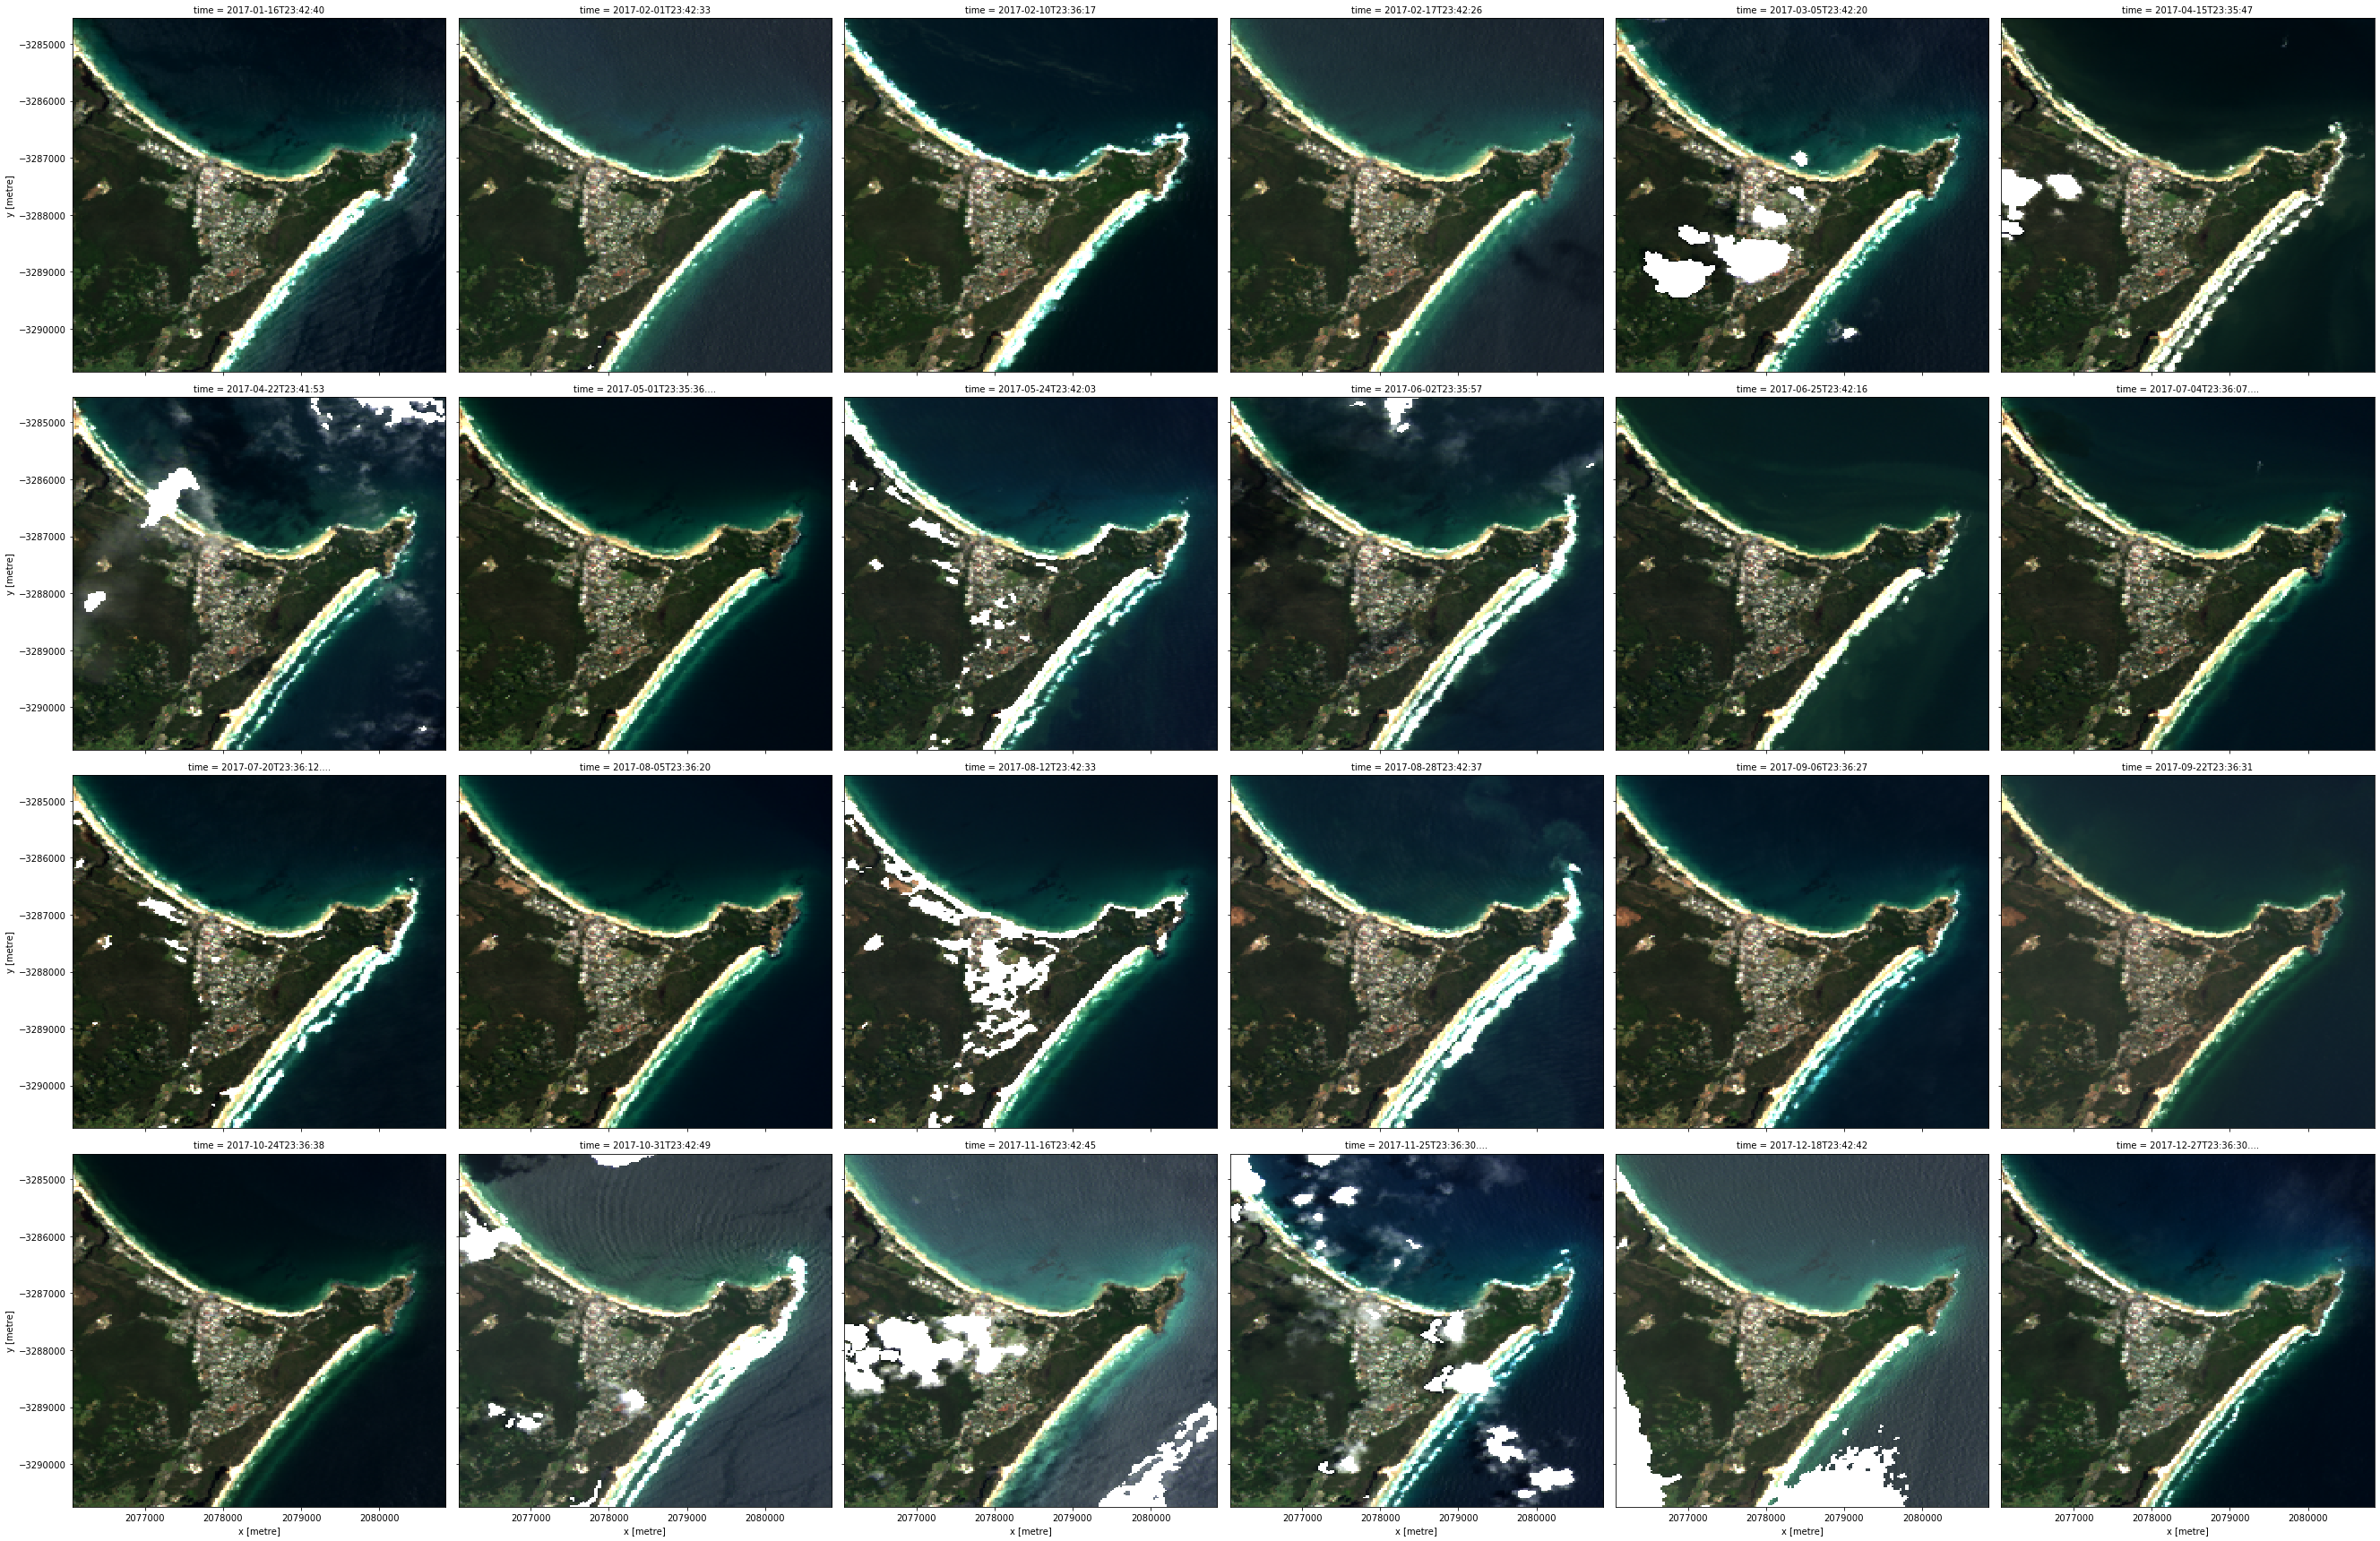

In [67]:
DEAPlotting.rgb(landsat_ds, col='time', col_wrap=6)

## Compute index to identify white water using ratio of near infrared to shortwave radiation

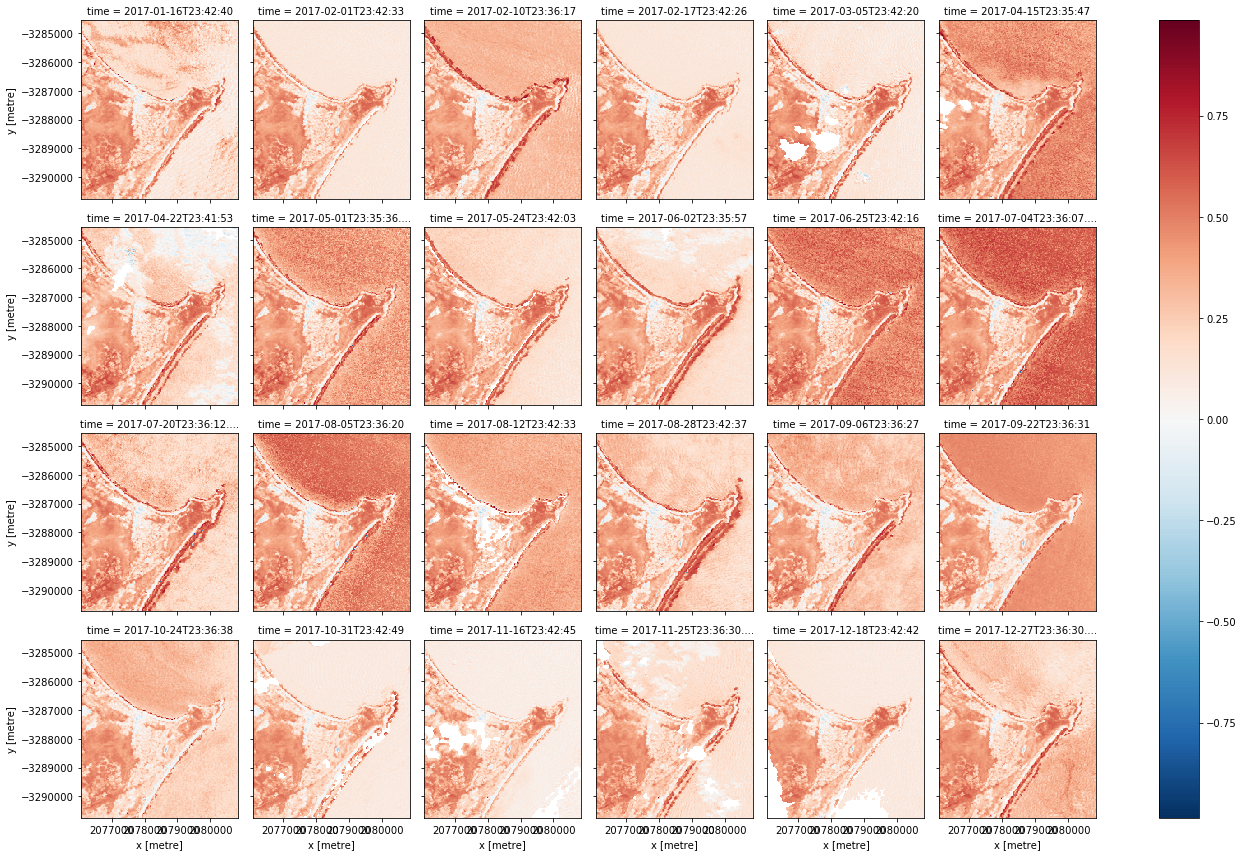

In [68]:
ndwwi = (landsat_ds.nir - landsat_ds.swir1) / (landsat_ds.nir + landsat_ds.swir1)
ndwwi.plot(col='time', col_wrap=6)

## Mask out land
As this index is intended for use over water, we can use the Modified Normalised Difference Water Index to mask out land pixels

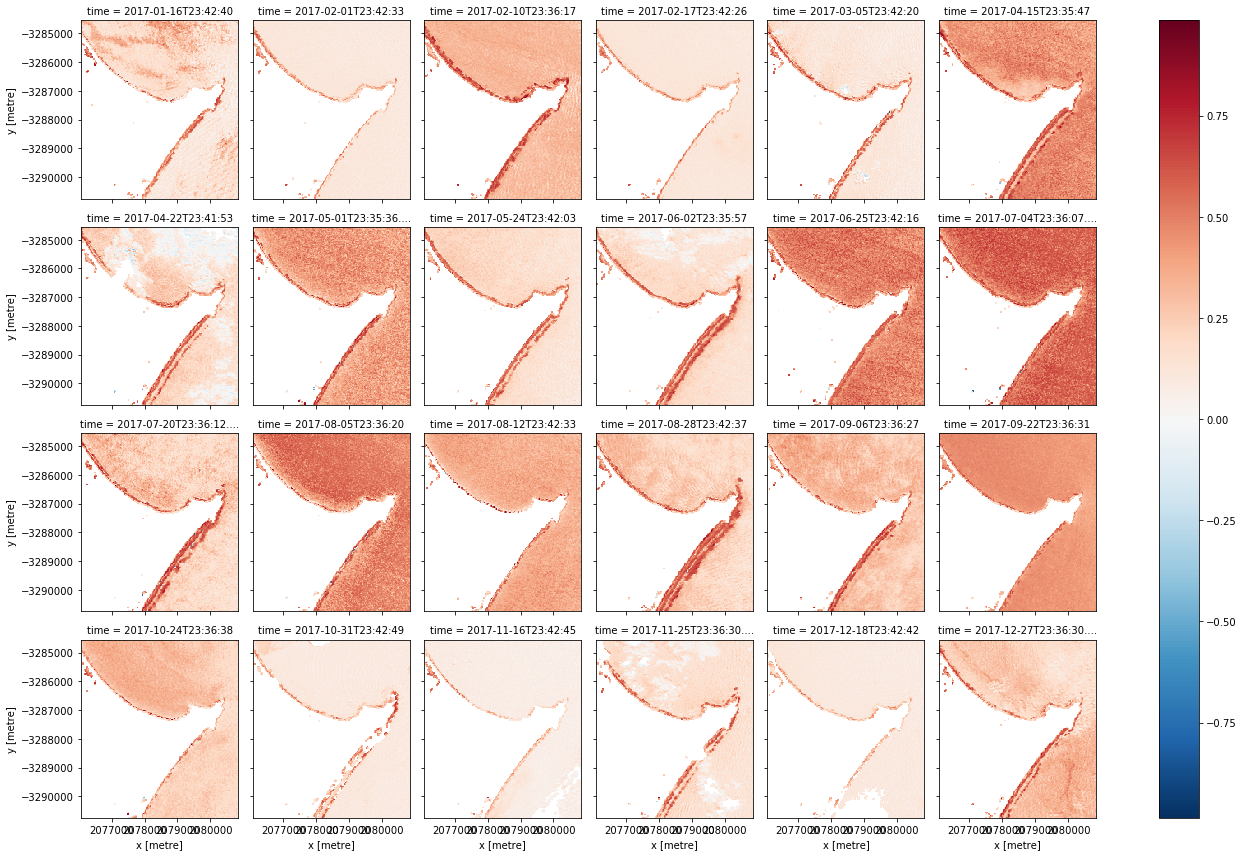

In [69]:
# First, calculate the MNDWI index, then test whether MNDWI value are 
# greater than 0 to create a mask with True = water, False = land
mndwi = (landsat_ds.green - landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1)
land_pixels = mndwi > 0

# Apply this mask to our white water index to remove land pixels
ndwwi_masked = ndwwi.where(land_pixels)

# Plot
ndwwi_masked.plot(col='time', col_wrap=6)

## Apply a threshold to extract white water
We can try and extract white water from the images above by creating a mask where NDWWI is higher than a certain threshold.
We've arbitrarily used 0.5 below - this isn't necessarily the best choice!

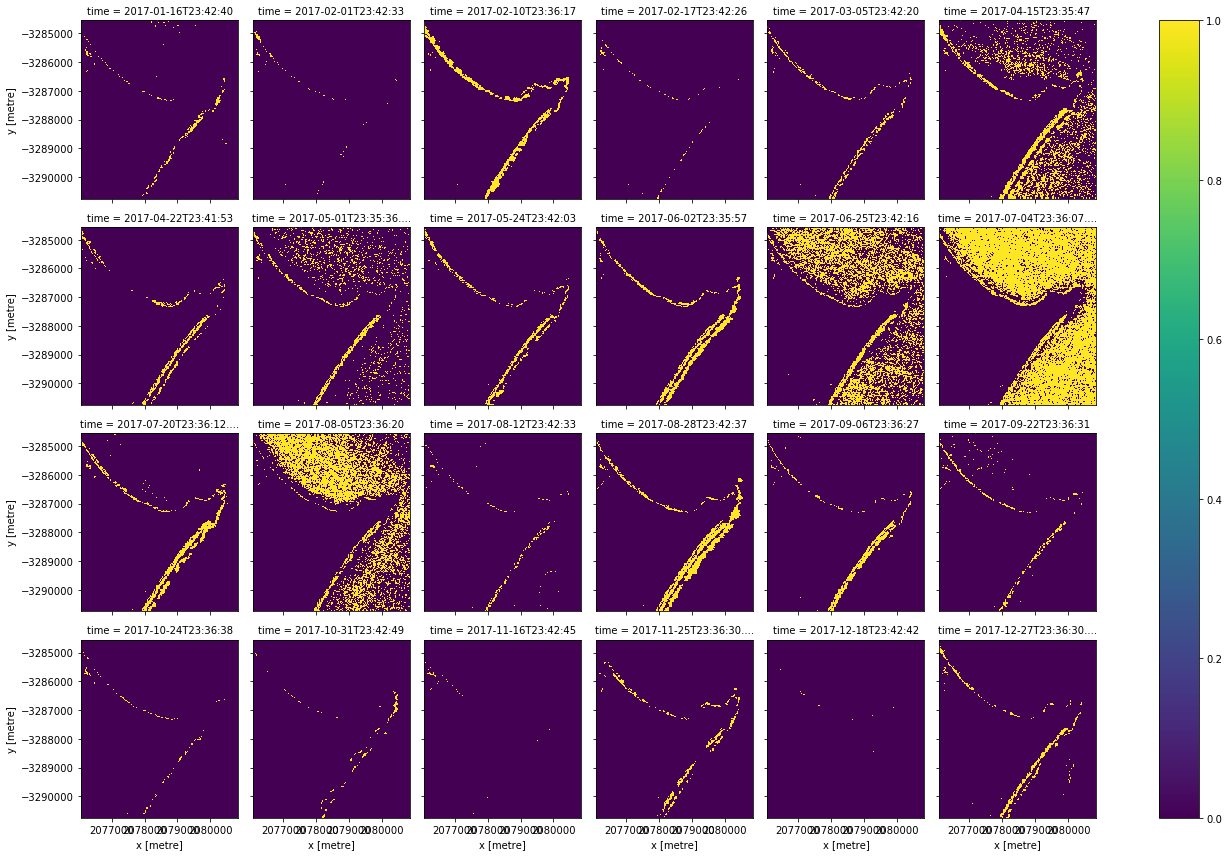

In [88]:
# Choose a threshold value
ndwwi_threshold = 0.5

# Apply the threshold value to the NDWWI data to get back a dataset where True = white water
white_water = ndwwi_masked > ndwwi_threshold

# Plot
white_water.plot(col='time', col_wrap=6)

## Calculate summary/frequency of white water
Now we have a dataset of possible white water, we can summarise it through time. Here we take the mean of all good/non-cloudy pixels through time - this will give us a proportion indicating how often each pixel was observed as white water throughout the time series:

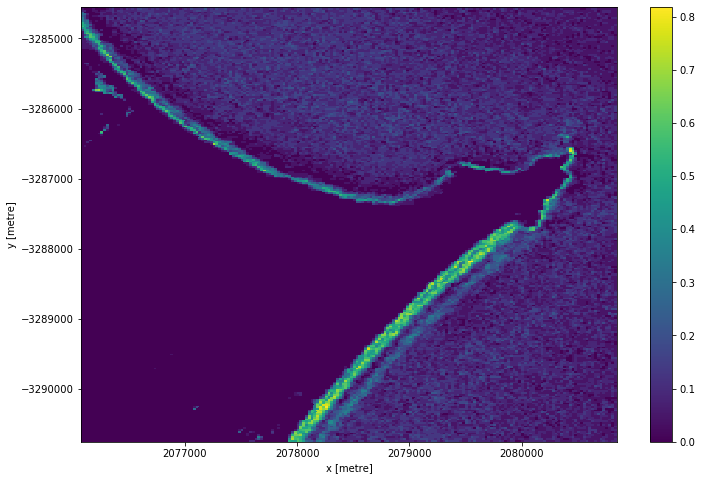

In [86]:
white_water.where(good_pixels).mean(dim='time').plot(size=8)

## Possible extra steps
In the "Apply a threshold" step, several of the images contain false positives in the deeper ocean areas due to certain wind/ocean colour conditions. These issues are in areas of deep blue ocean, so a potential way to fix them could be to filter our data to only keep white water identified in areas with bright white pixels.

Filtering based on the "blue" band could be a way to do this (there's probably many other ways, including developing a more complex index that takes into account water brightness):

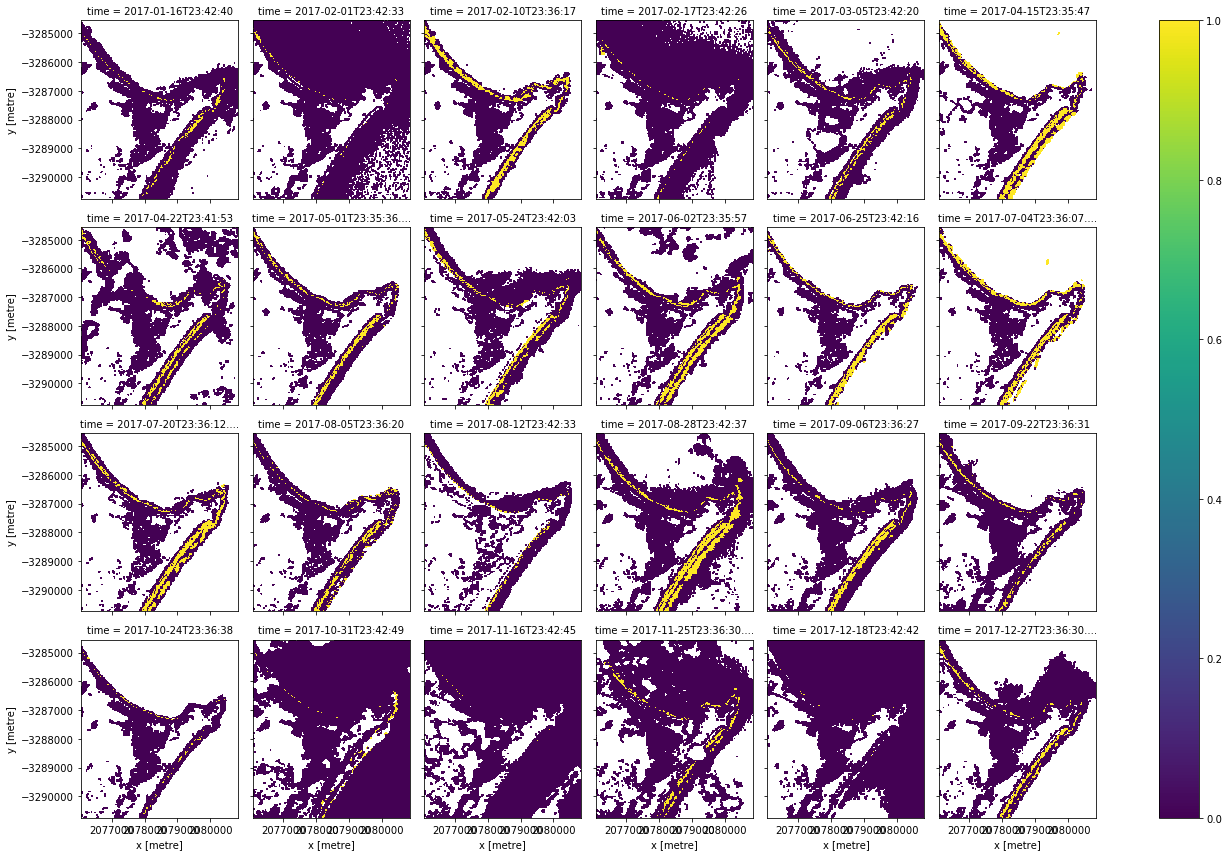

In [93]:
blue_threshold = 500
 
white_water.where(landsat_ds.blue > blue_threshold).plot(col='time', col_wrap=6)

<script src="https://embed.github.com/view/geojson/benbalter/dc-wifi-social/master/bars.geojson"></script>
